,data_type,species,diff_ratio,r_avg,r_std
0,BBv2,Bacillus,0.085350,0.901639,0.629348
1,BBv2,Lactobacillus,0.043631,0.644803,0.632986
2,BBv2,Listeria,0.028263,0.927714,0.668012
3,BBv2,Enterococcus,0.006764,0.932696,0.751467
4,BBv2,Staphylococcus,0.005871,0.921642,0.758139


,species,align_ratio,pred_ratio
0,Bacillus,20.53,11.31
1,Lactobacillus,16.36,11.20
2,Listeria,14.83,9.70
3,Enterococcus,12.68,12.60
4,Staphylococcus,12.59,12.62


align RMSE:  4.487157711575302
adjust RMSE:  1.1964120603293162
1 1 x y x^2 y^2
1 1 x y x^2 y^2 x^3 y^3
[ 0.00000000e+00  1.45803369e-11  6.29373998e+02 -1.16415711e+03
 -6.71517115e+02  1.28253943e+03  2.33884793e+02 -4.73343829e+02]


<IPython.core.display.Javascript object>


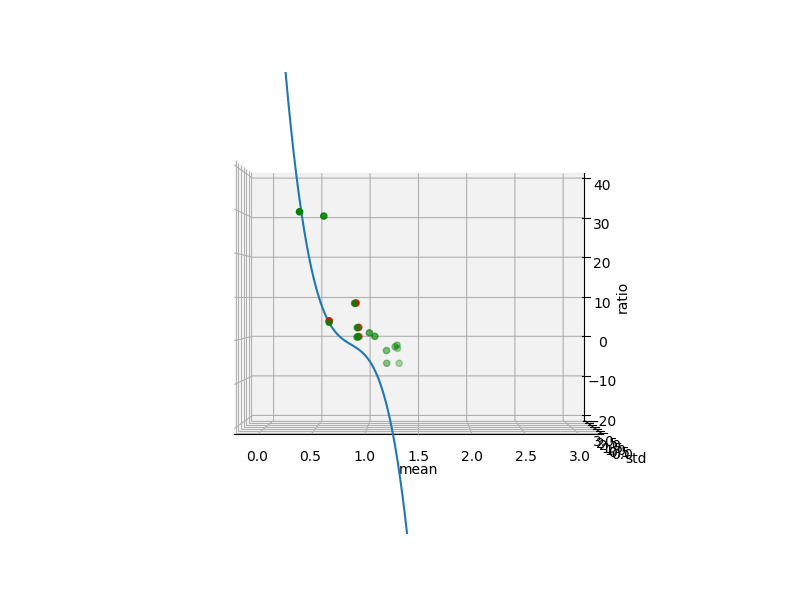

<IPython.core.display.Javascript object>


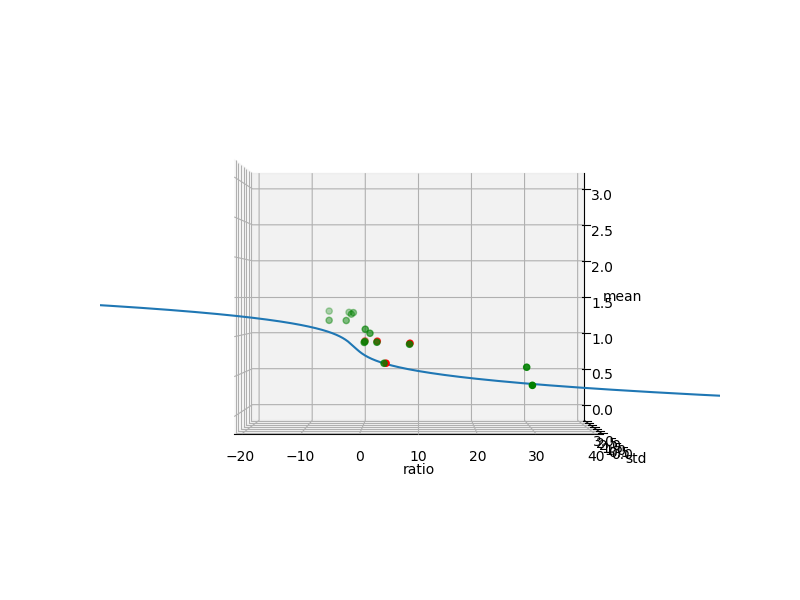

In [176]:
%matplotlib notebook
%run data_path.ipynb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from mpl_toolkits import mplot3d
import numpy as np

loman = [7.32,  2.56,  0.24, -0.72, -2.01, -2.07, -2.30, -2.72, -0.08, -0.22]

k=3
sample= "BBv2"
truer = [12] * 5
gram = gram_pos

regr_df = pd.read_excel("regression_data.xlsx")
# regr_df.rename(columns={"ratio diff.":"diff_ratio", "relative avg":"r_avg", "relative std":"r_std"}, inplace=True)
test_df = regr_df[regr_df.data_type == sample]
train_df = regr_df[regr_df.data_type != sample]
train_df = train_df[train_df.data_type != "BBv1"]
train_df = train_df[train_df.data_type != "MPZv1"]
# display(train_df)

train_df = train_df[train_df.species.isin(gram)]
test_df = test_df[test_df.species.isin(gram)]

# train_df = train_df[train_df.species != "Lactobacillus"]
# test_df = test_df[test_df.species != "Lactobacillus"]
display(test_df)

train_x = train_df[["r_avg","r_std"]].values.tolist()
train_y = train_df["diff_ratio"].values.tolist()
# train_x = [[x*100,y*100] for x,y in train_x]
train_y = [x*100 for x in train_y]
test_x = test_df[["r_avg","r_std"]].values.tolist()
test_y = test_df["diff_ratio"].values.tolist()
# test_x = [[x*100,y*100] for x,y in test_x]
test_y = [x*100 for x in test_y]
# print(test_y)

# poly = PolynomialFeatures(degree=1)
X_ = np.array(train_x)
tX_ = np.array(test_x)
X_ = np.hstack([X_**(i) for i in np.arange(k+1)])
testX_ = np.hstack([tX_**(i) for i in np.arange(k+1)])
# X_ = poly.fit_transform(train_x)
# testX_ = poly.fit_transform(test_x)
model = LinearRegression()
model.fit(X_, train_y)
pred_y = model.predict(testX_)

pred_df = test_df.copy()
pred_df.drop(["data_type","r_avg","r_std"], inplace=True, axis=1)
pred_df.insert(loc=2,column="pred_ratio", value=pred_y)

pred_df.diff_ratio = pred_df.diff_ratio * 100 + 12
pred_df.rename(columns={"diff_ratio":"align_ratio"}, inplace=True)
pred_df.eval('pred_ratio = align_ratio - pred_ratio', inplace=True)
display(pred_df.round(2))
print("align RMSE: ",np.sqrt(mean_squared_error(truer, pred_df['align_ratio'])))
print("adjust RMSE: ",np.sqrt(mean_squared_error(truer, pred_df['pred_ratio'])))
print("1 1 x y x^2 y^2")
print("1 1 x y x^2 y^2 x^3 y^3")
print(model.coef_)

tx1,tx2 = zip(*test_x)
trx1,trx2 = zip(*train_x)
line_x1 = np.linspace(0,3,1000)
line_x2 = np.linspace(0,3,1000)
x12=list(zip(line_x1,line_x2))
X12_ = np.array(x12)
x12_ = np.hstack([X12_**(i) for i in np.arange(k+1)])
# x12_ = poly.fit_transform(x12)

line_y = model.predict(x12_)

# line_x1, line_x2 = np.meshgrid(line_x1, line_x2)

pt = {
   "linep":{
       "ratio":line_y,
       "mean":line_x1,
       "std":line_x2
   },
    "trainp":{
       "ratio":train_y,
       "mean":trx1,
       "std":trx2
   },
    "testp":{
       "ratio":test_y,
       "mean":tx1,
       "std":tx2
   }
}
def ratio_coord_limit(ax,dx,dy,dz):
    if dx == "ratio":
        ax.set_xlim3d(-20,40)
    if dy == "ratio":
        ax.set_ylim3d(-20,40)
    if dz == "ratio":
        ax.set_zlim3d(-20,40)

def plot_regre(dx,dy,dz):
    fig = plt.figure(figsize=(8,6))
    ax = plt.axes(projection='3d')
    ax.set_xlabel(dx)
    ax.set_ylabel(dy)
    ax.set_zlabel(dz)
    ratio_coord_limit(ax,dx,dy,dz)
    ax.plot3D(pt["linep"][dx], pt["linep"][dy], pt["linep"][dz])
#     ax.plot_wireframe(pt["linep"][dx], pt["linep"][dy], pt["linep"][dz], rcount=20,ccount=20)
#     ax.plot_surface(pt["linep"][dx], pt["linep"][dy], pt["linep"][dz])
    ax.scatter3D(pt["trainp"][dx], pt["trainp"][dy], pt["trainp"][dz],c='green')
    ax.scatter3D(pt["testp"][dx], pt["testp"][dy], pt["testp"][dz],c='red')
    ax.view_init(0,-90)
    plt.show()

# dxyz = ("ratio", "mean", "std")
dxyz = ("mean", "std","ratio")
plot_regre(*dxyz)
dxyz2 = ("ratio", "std", "mean")
plot_regre(*dxyz2)